In [21]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [ ]:
# Run src/data/combine_annotations.py first to generate the combined annotations file

In [15]:
frames = ["Economic","Capacity and resources","Morality","Fairness and equality","Legality, constitutionality and jurisprudence","Policy prescription and evaluation","Crime and punishment","Security and defense","Health and safety","Quality of life","Cultural identity","Public opinion","Political","External regulation and reputation","Other"]
frames = [f.lower() for f in frames]

In [8]:
analysis_path = Path('/projects/frame_align/data/annotated/analysis')
text_analysis_path = analysis_path / 'text'
vision_analysis_path = analysis_path / 'vision'

In [9]:
combined_df = pd.read_csv(analysis_path/'combined_annotations.csv')

In [11]:
combined_df.columns

Index(['text_topic', 'text_topic_justification', 'text_summary',
       'text_entity_name', 'text_justification_entity_sentiment',
       'text_entity_sentiment', 'text_frame_justification', 'text_frame_id',
       'text_frame_name', 'text_tone', 'text_justification_tone',
       'text_issue_frame', 'text_issue_frame_justification', 'text_id',
       'vision_caption', 'vision_main-actor', 'vision_sentiment',
       'vision_sentiment-justification', 'vision_facial-expression',
       'vision_facial-expression-justification', 'vision_perceivable-gender',
       'vision_perceivable-gender-justification', 'vision_symbolic-object',
       'vision_symbolic-meaning', 'vision_symbolic-meaning-explanation',
       'vision_frame-id', 'vision_frame-name', 'vision_frame-justification',
       'vision_image_url', 'vision_title', 'vision_uuid'],
      dtype='object')

In [16]:
combined_df['text_frame_name'] = combined_df['text_frame_name'].str.lower()
combined_df['vision_frame-name'] = combined_df['vision_frame-name'].str.lower()

In [17]:
text_valid = combined_df['text_frame_name'].isin(frames)
vision_valid = combined_df['vision_frame-name'].isin(frames)
intersection = text_valid & vision_valid
combined_df = combined_df[intersection]

In [18]:
sum(combined_df['text_frame_name'] == combined_df['vision_frame-name'])/len(combined_df)

0.12260766709972659

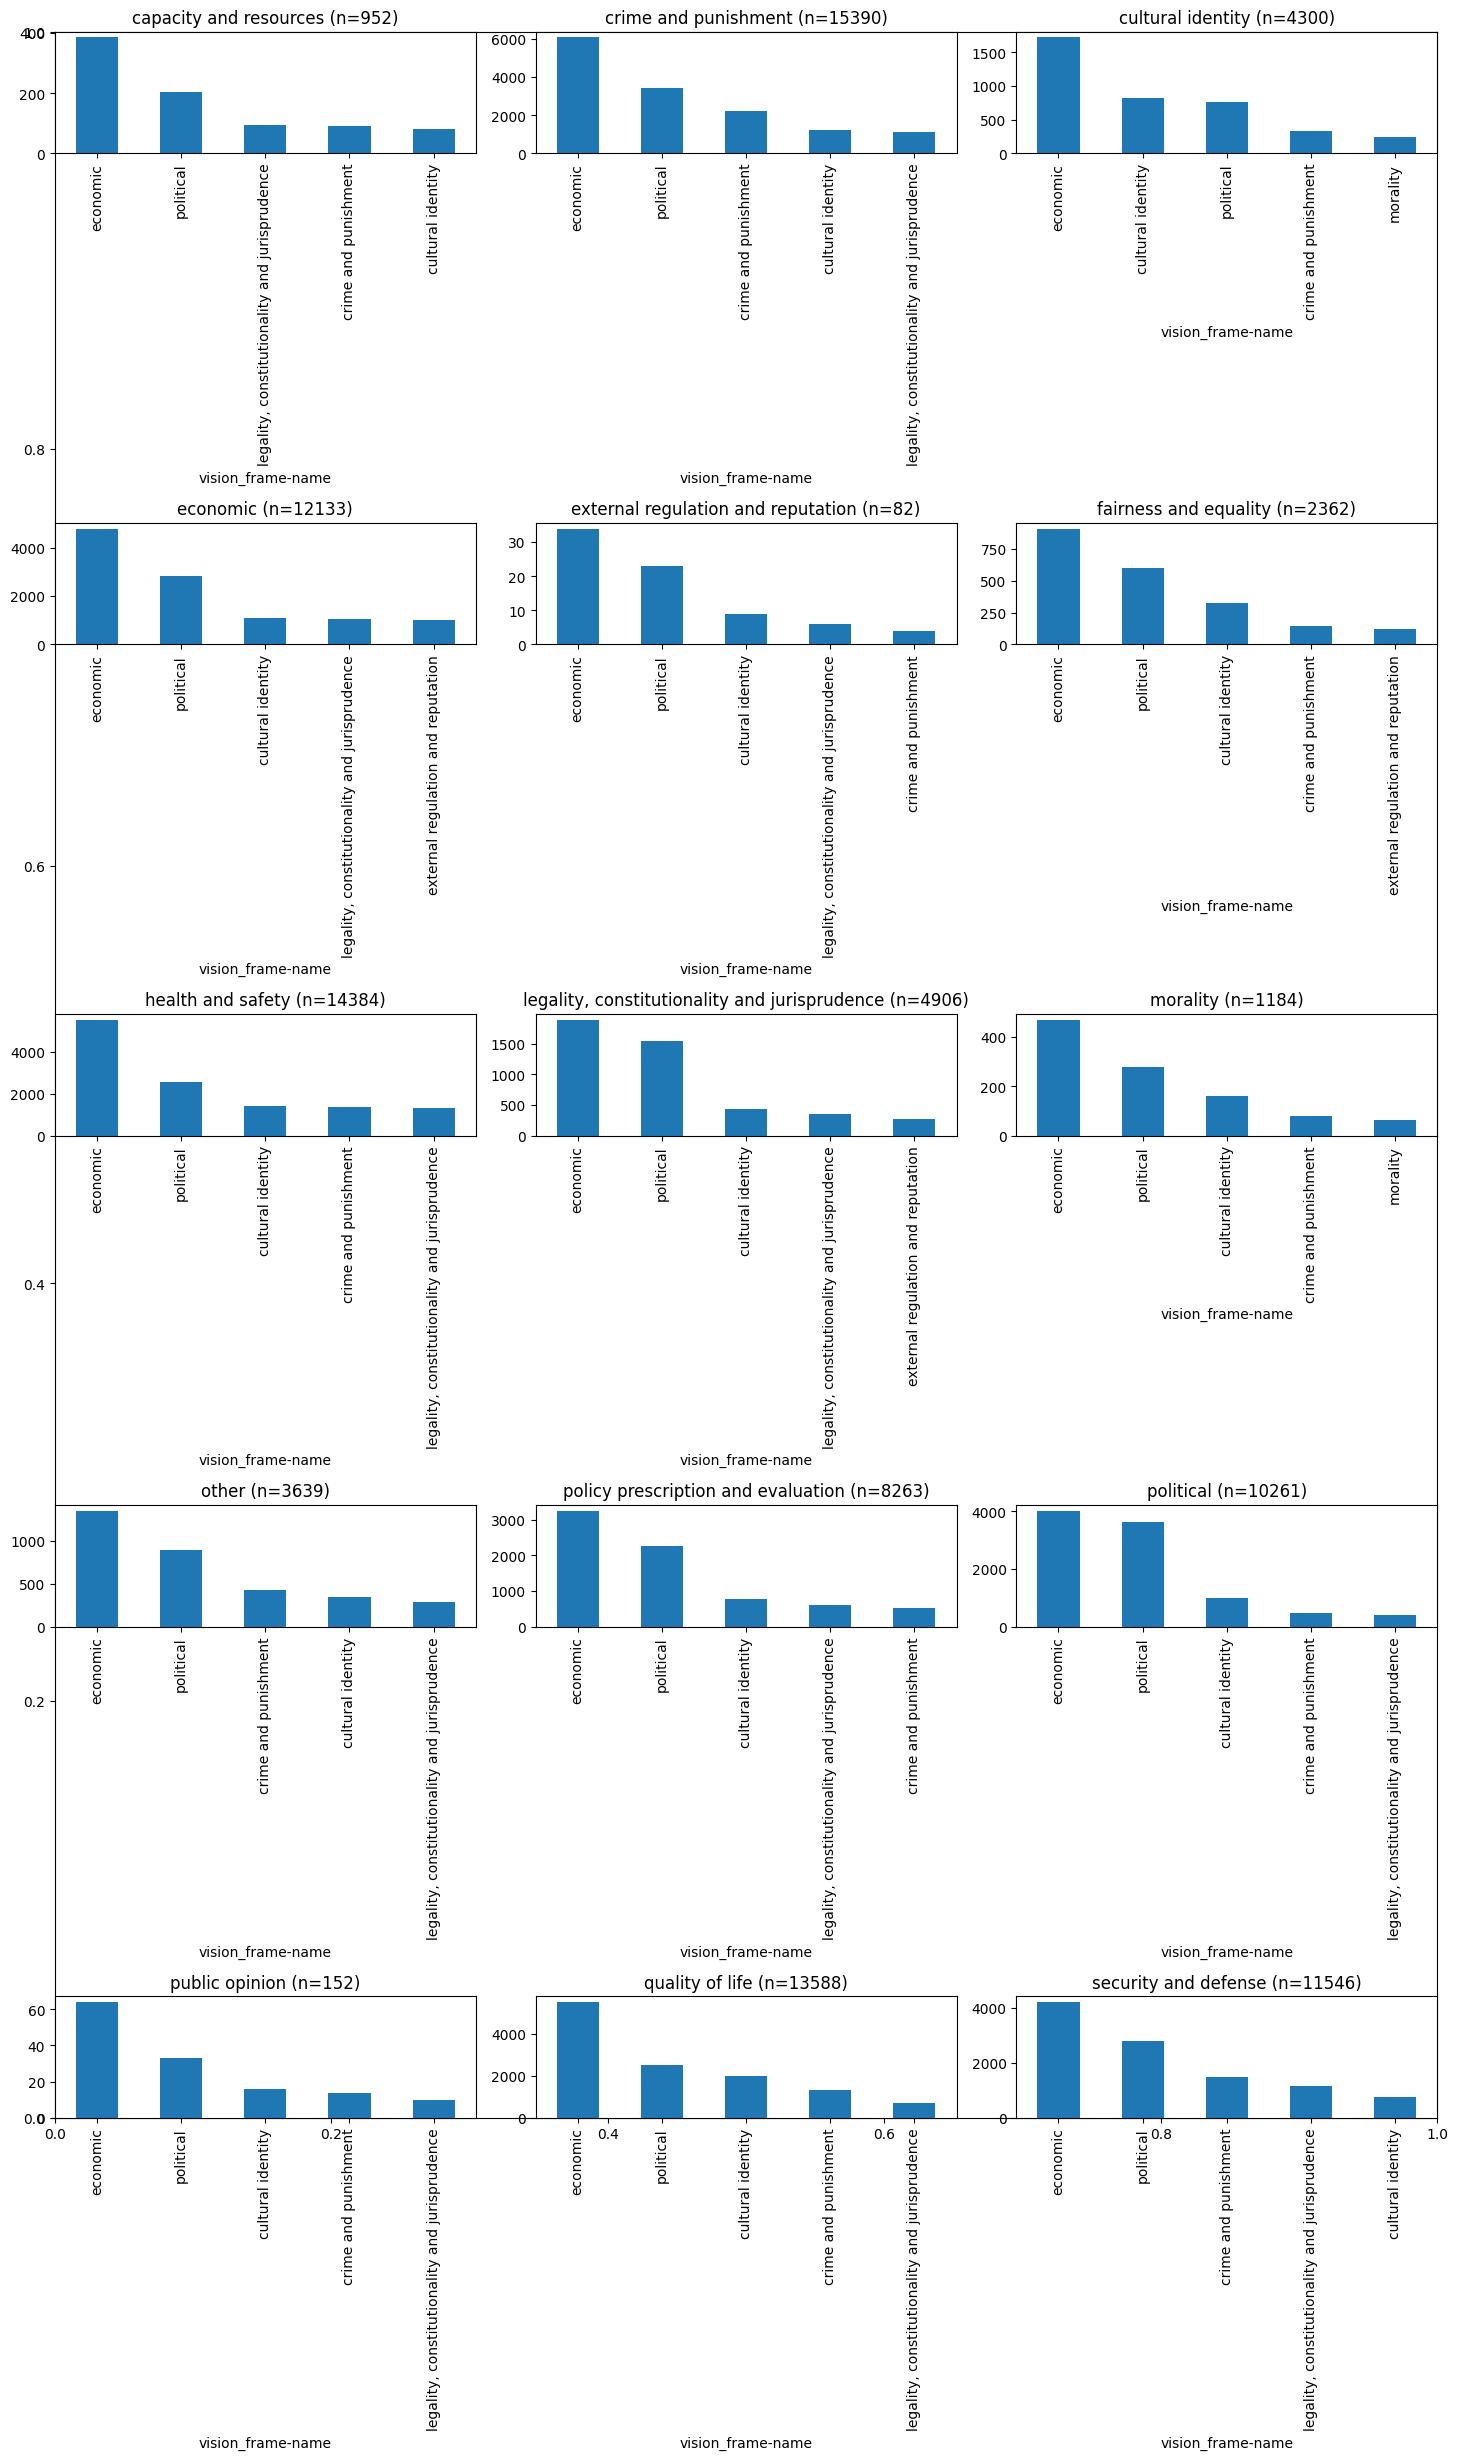

In [32]:
# Top vision frames for each text frame
plt.subplots(figsize=(15,25))
for i, (group_name, group) in enumerate(combined_df.groupby('text_frame_name')):
    plt.subplot(5,3,i+1)
    group['vision_frame-name'].value_counts()[:5].plot(kind='bar')
    plt.title(group_name+' (n='+str(len(group))+')')
    # plt.xticks(rotation=45)
    plt.tight_layout()


In [35]:
combined_df.to_csv(analysis_path/'combined_annotations_filtered.csv', index=False)

In [36]:
len(combined_df)

103142

In [38]:
uuids = combined_df['text_id'].unique()
len(uuids)

103142

In [41]:
annotated_articles = []
data_dir = Path('/projects/frame_align/data/raw/2023-2024/')
for month_dir in data_dir.iterdir():
    if not month_dir.is_dir():
        continue
    df = pd.read_csv(month_dir/"datawithtopiclabels.csv")
    df = df[df['id'].isin(uuids)]
    annotated_articles.append(df)
annotated_articles = pd.concat(annotated_articles)
annotated_articles.to_csv(analysis_path/'annotated_articles.csv', index=False)

In [43]:
combined_df = combined_df.merge(annotated_articles[['id','topic_label']], left_on='text_id', right_on='id', how='left')

In [44]:
len(combined_df['topic_label'].unique())

11

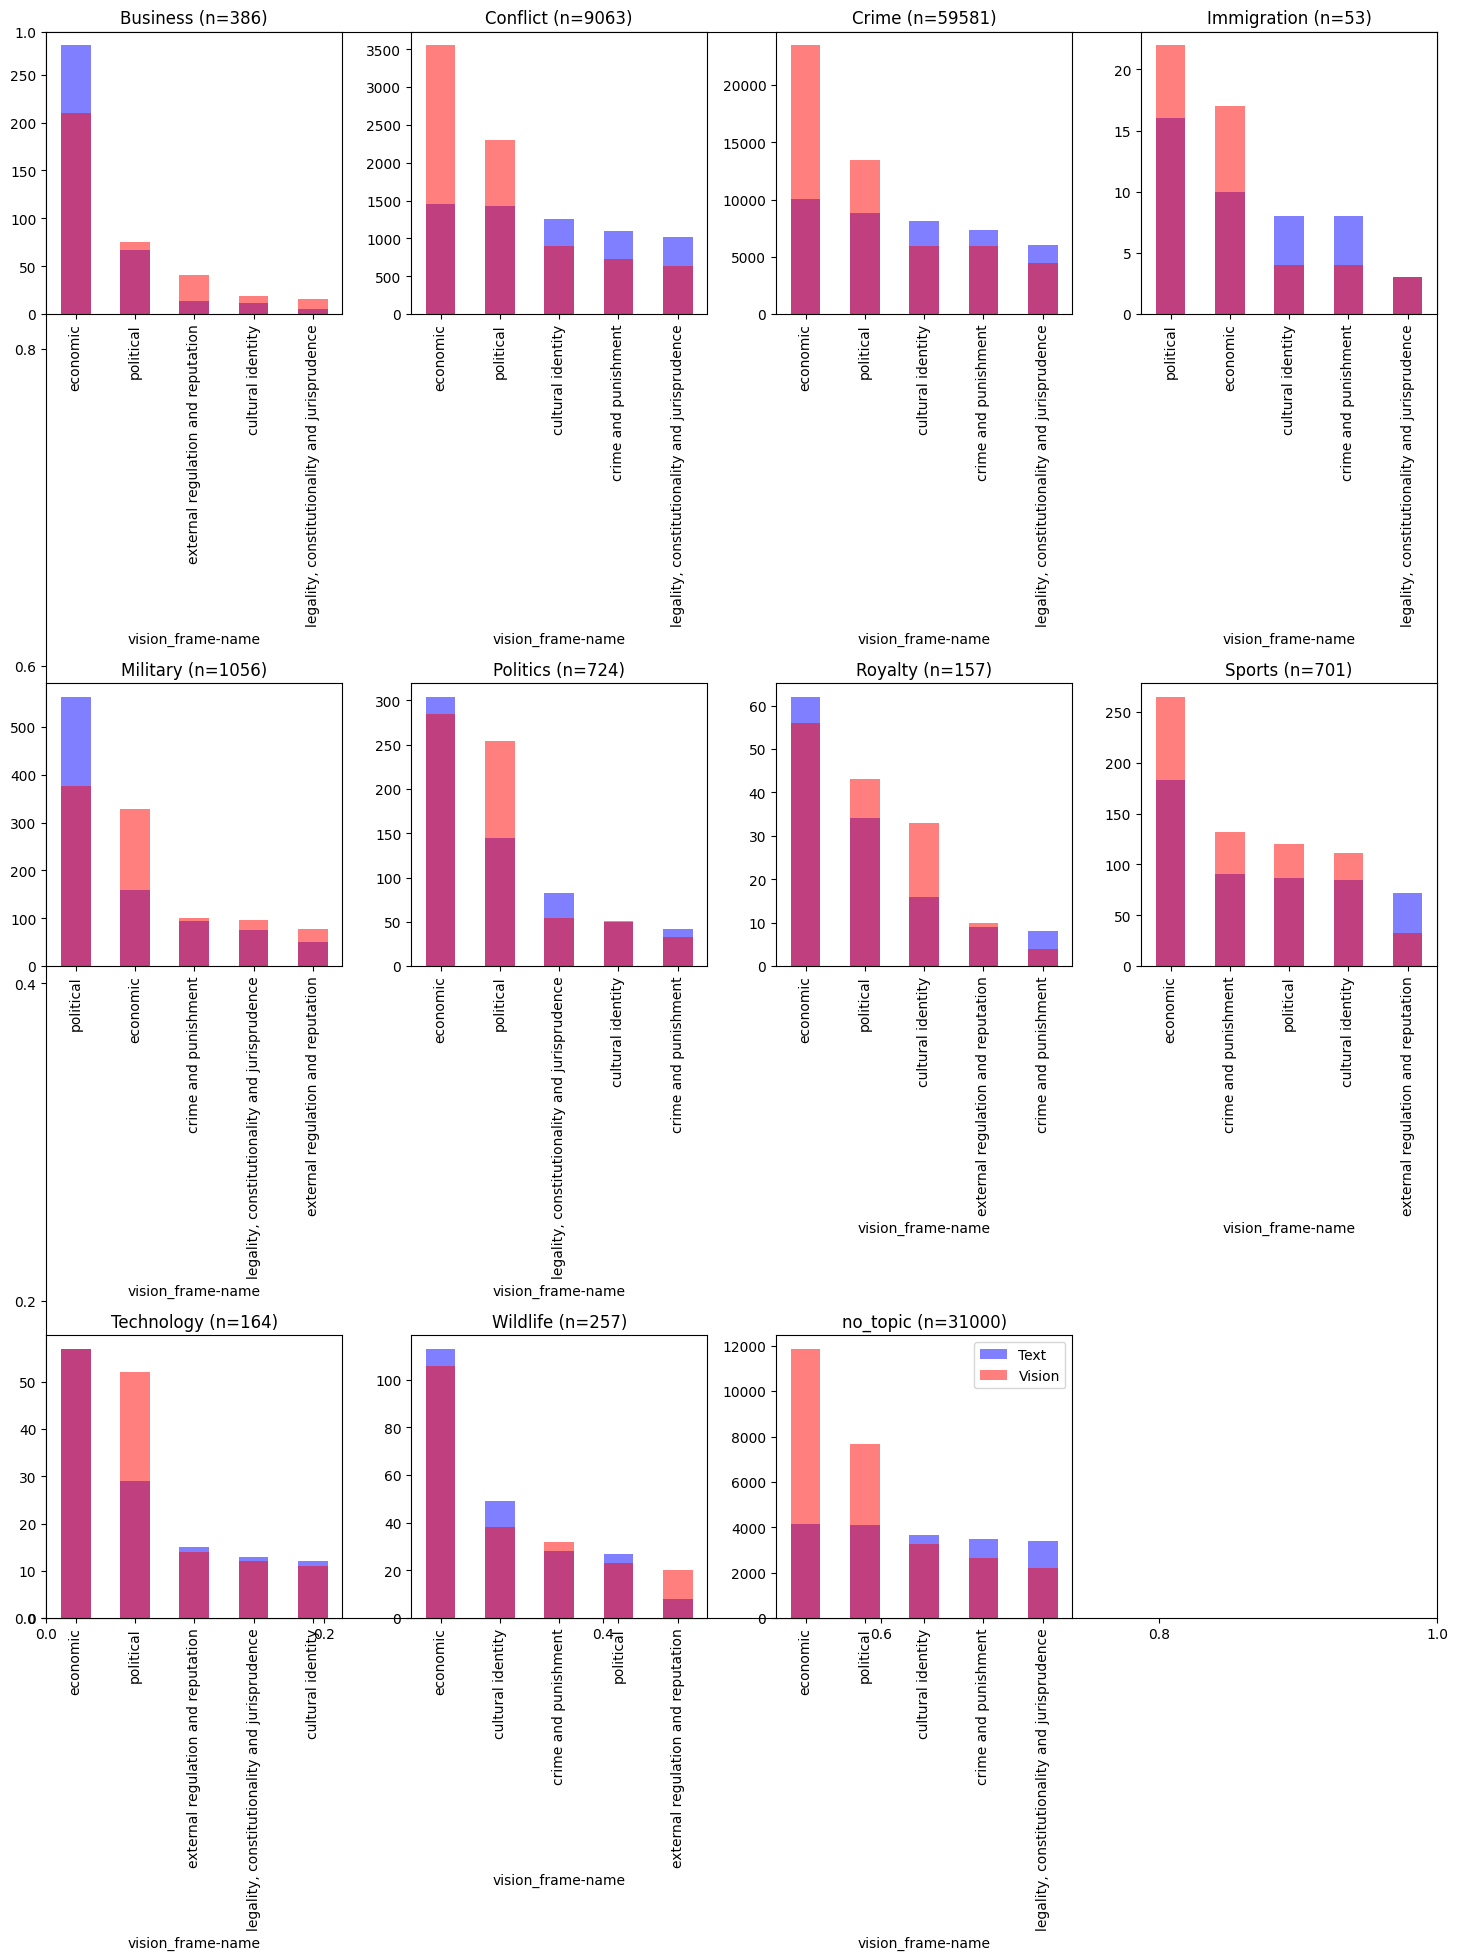

In [54]:
# Top text and vision frames per topic in grouped bar chart
plt.subplots(figsize=(15,20))
for i, (group_name, group) in enumerate(combined_df.groupby('topic_label')):
    plt.subplot(3,4,i+1)
    group['text_frame_name'].value_counts()[:5].plot(kind='bar', color='blue', alpha=0.5)
    group['vision_frame-name'].value_counts()[:5].plot(kind='bar', color='red', alpha=0.5)
    plt.title(group_name+' (n='+str(len(group))+')')
    plt.tight_layout()
plt.legend(['Text','Vision'])
